# DistilBERT Fine-Tuning with PyTorch

In this notebook, we trained DistilBERT on the large amazon reviews dataset. The dataset was already split into train, validation and test set, which are preprocessed and ready to use from the data_2 file. The dataset is available [here](https://www.kaggle.com/datasets/machharavikiran/amazon-reviews).

The results are discussed in the report.

In [1]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /home/g.criscione2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/g.criscione2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/g.criscione2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long) 
        return item

class DistilBertModelBuilder:
    def __init__(self, num_labels, max_length=512):
        # Il tokenizer è definito come attributo della classe qui
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
        self.max_length = max_length
        self.trainer = None

    def train(self, X_train, y_train, X_val, y_val, epochs=3, batch_size=8):
        # Utilizzo del tokenizer definito nell'oggetto
        train_dataset = SentimentDataset(X_train, y_train, self.tokenizer, self.max_length)
        val_dataset = SentimentDataset(X_val, y_val, self.tokenizer, self.max_length)
        
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        self.trainer.train()

    def predict(self, X_test, y_test):
        test_dataset = SentimentDataset(X_test, y_test, self.tokenizer, self.max_length)
        predictions = self.trainer.predict(test_dataset)
        print(f"Predictions shape: {predictions.predictions.shape}") 
        print(f"Label shape: {predictions.label_ids.shape}")  
        y_pred = np.argmax(predictions.predictions, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f'F1 score: {f1:.2f}')
        print(f'Accuracy: {accuracy:.2f}')
        print(classification_report(y_test, y_pred)) 
        return y_pred

    def get_model(self):
        return self.model

In [4]:
from data_2 import X_train, y_train, X_val, y_val

Training data preprocessed successfully!


In [5]:
model = DistilBertModelBuilder(num_labels=5)
model.train(X_train, y_train, X_val, y_val, epochs=3, batch_size=8)

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: d-bedini2 (bedo). Use `wandb login --relogin` to force relogin


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,1.615200
20,1.613300
30,1.608500
40,1.610300
50,1.608800
60,1.609000
70,1.594100
80,1.607900
90,1.599800
100,1.601400


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [6]:
from data_2 import X_test, y_test, X_test_balanced, y_test_balanced

X_test type: <class 'list'>, shape: (900,)
y_test type: <class 'list'>, shape: (900,)


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (900, 5)
Label shape: (900,)
F1 score: 0.56
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       150
           1       0.44      0.43      0.43       150
           2       0.38      0.42      0.40       150
           3       0.39      0.37      0.38       150
           4       0.78      0.77      0.78       300

    accuracy                           0.56       900
   macro avg       0.52      0.52      0.52       900
weighted avg       0.56      0.56      0.56       900



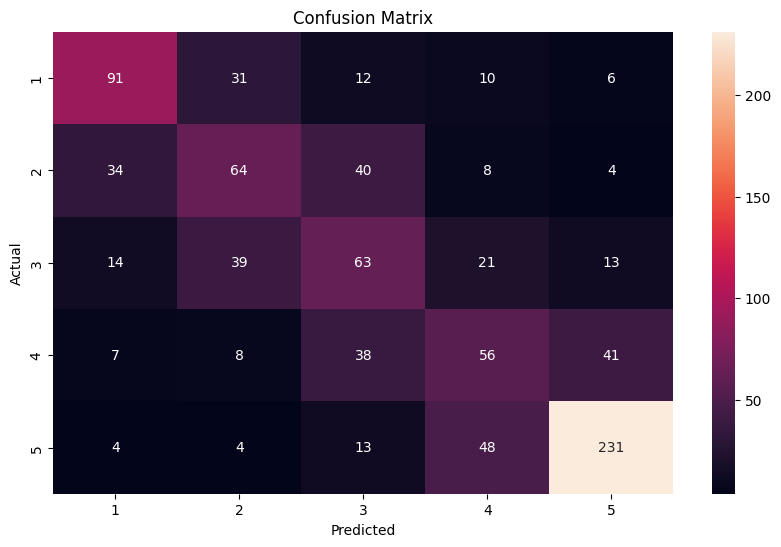

X_test type: <class 'list'>, shape: (1500,)
y_test type: <class 'list'>, shape: (1500,)


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (1500, 5)
Label shape: (1500,)
F1 score: 0.52
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       300
           1       0.44      0.42      0.43       300
           2       0.40      0.42      0.41       300
           3       0.48      0.42      0.45       300
           4       0.66      0.77      0.71       300

    accuracy                           0.52      1500
   macro avg       0.52      0.52      0.52      1500
weighted avg       0.52      0.52      0.52      1500



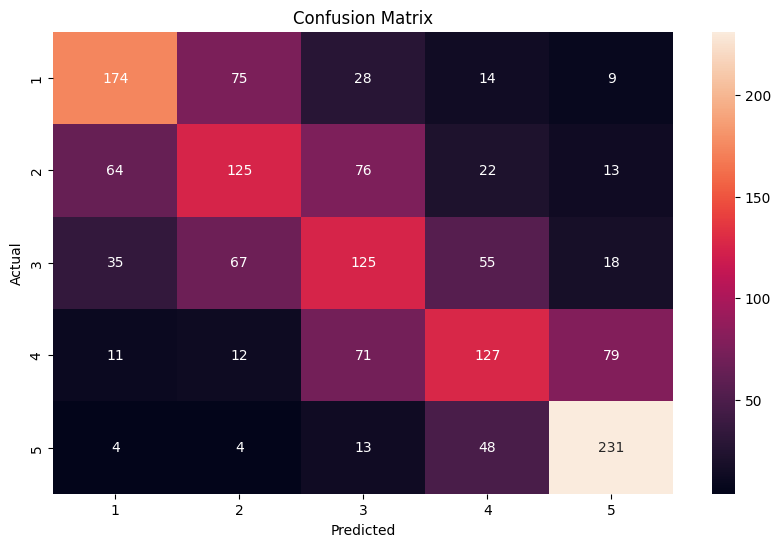

In [7]:
def plot_cm_distilbert(model, X_test, y_test):
    """Plots the confusion matrix for the distilBERT model."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Debugging: Print input shapes and types
    print(f"X_test type: {type(X_test)}, shape: {np.shape(X_test)}")
    print(f"y_test type: {type(y_test)}, shape: {np.shape(y_test)}")
    
    # Call the predict function
    y_pred = model.predict(X_test, y_test)
    
    # Debugging: Print the output of the predict function
    #print(f"y_pred: {y_pred}")

    if y_pred is None:
        raise ValueError("model.predict returned None")

    #y_pred = [np.argmax(pred) for pred in y_pred]
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=[i for i in range(1, 6)], columns=[i for i in range(1, 6)])
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example usage:
plot_cm_distilbert(model, X_test, y_test)

plot_cm_distilbert(model, X_test_balanced, y_test_balanced)
